## Reuters 딥러닝 모델

### 데이터 로드 및 전처리

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import models, layers, callbacks, optimizers
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing.sequence import pad_sequences

tf.keras.utils.set_random_seed(42)

In [2]:
(train_data_all, train_labels_all), (test_data, test_labels) = reuters.load_data(num_words=10000)
train_data, val_data, train_labels, val_labels = train_test_split(train_data_all, train_labels_all, 
                                                                  test_size=0.25, random_state=123, 
                                                                  stratify=train_labels_all)
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(set(train_labels)))

6736
2246
2246
46


In [3]:
def one_hot_encoding(data, dim=10000):
    x = np.zeros((len(data), dim), dtype="float32")
    for i, seq in enumerate(data):
        seq = [w for w in seq if w < dim]
        x[i, seq] = 1.0
    return x

x_train = one_hot_encoding(train_data)
x_val   = one_hot_encoding(val_data)
x_test  = one_hot_encoding(test_data)

In [4]:
num_classes = np.max(train_labels) + 1
y_train = utils.to_categorical(train_labels, num_classes)
y_val   = utils.to_categorical(val_labels,   num_classes)
y_test  = utils.to_categorical(test_labels,  num_classes)

### 모델 구성 및 컴파일

In [5]:
model = models.Sequential([
    layers.Input(shape=(10000,)),
    layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2560256   
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

### 모델 학습

In [6]:
mc = callbacks.ModelCheckpoint('reuters_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = model.fit(x_train, y_train, epochs=30, batch_size=512, 
                    validation_data=(x_val, y_val), callbacks=[mc, es], verbose=1)

Epoch 1/30
13/14 [==========================>...] - ETA: 0s - loss: 3.1914 - accuracy: 0.3586
Epoch 1: val_loss improved from inf to 3.22343, saving model to reuters_best.h5
14/14 [==============================] - 2s 81ms/step - loss: 3.1866 - accuracy: 0.3603 - val_loss: 3.2234 - val_accuracy: 0.6189
Epoch 2/30
 1/14 [=>............................] - ETA: 0s - loss: 1.9997 - accuracy: 0.5742

c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/14 [==========================>...] - ETA: 0s - loss: 1.6080 - accuracy: 0.6603
Epoch 2: val_loss improved from 3.22343 to 2.73127, saving model to reuters_best.h5
14/14 [==============================] - 1s 63ms/step - loss: 1.6042 - accuracy: 0.6611 - val_loss: 2.7313 - val_accuracy: 0.7012
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 1.1515 - accuracy: 0.7538
Epoch 3: val_loss improved from 2.73127 to 2.43399, saving model to reuters_best.h5
14/14 [==============================] - 1s 67ms/step - loss: 1.1494 - accuracy: 0.7539 - val_loss: 2.4340 - val_accuracy: 0.7142
Epoch 4/30
13/14 [==========================>...] - ETA: 0s - loss: 0.9109 - accuracy: 0.7976
Epoch 4: val_loss improved from 2.43399 to 2.25724, saving model to reuters_best.h5
14/14 [==============================] - 1s 64ms/step - loss: 0.9122 - accuracy: 0.7969 - val_loss: 2.2572 - val_accuracy: 0.7061
Epoch 5/30
13/14 [==========================>...] - ETA: 0s - loss: 0.7333 - accuracy: 

### 모델 평가 및 예측

C:\Users\Administrator\AppData\Local\Temp;\ipykernel_12024\4093518857.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


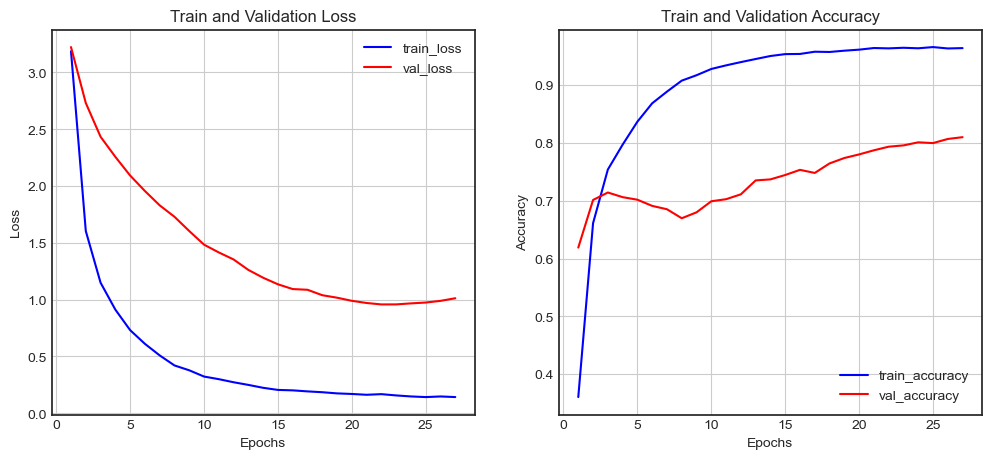

In [7]:
plt.style.use('seaborn-white')

history_dict = history.history
loss = history_dict['loss'];        val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']; val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss'); ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss')
ax1.grid(); ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy'); ax2.set_xlabel('Epochs'); ax2.set_ylabel('Accuracy')
ax2.grid(); ax2.legend()

plt.show()

In [8]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

Test loss: 0.9901, Test accuracy: 0.7872


---
## 추가 실습

In [10]:
max_words = 10000
maxlen = 300  

(x_train_all, y_train_all), (x_test, y_test) = reuters.load_data(num_words=max_words)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, test_size=0.25, 
                                                  random_state=123, stratify=y_train_all)

x_train = pad_sequences(x_train, maxlen=maxlen)
x_val   = pad_sequences(x_val,   maxlen=maxlen)
x_test  = pad_sequences(x_test,  maxlen=maxlen)

num_classes = int(np.max(y_train_all) + 1)

print(f"Train: {x_train.shape}, Val: {x_val.shape}, Test: {x_test.shape}, #classes={num_classes}")

Train: (6736, 300), Val: (2246, 300), Test: (2246, 300), #classes=46


In [ ]:
def plot_history(history, title_suffix=""):
    H = history.history
    epochs = range(1, len(H['loss']) + 1)
    acc = H.get('accuracy') or H.get('acc')
    val_acc = H.get('val_accuracy') or H.get('val_acc')
    best_idx = int(np.argmin(H['val_loss']))

    print(f"[Train] final loss={H['loss'][-1]:.4f}, acc={acc[-1]:.4f}")
    print(f"[Valid] best  loss={H['val_loss'][best_idx]:.4f} (epoch {best_idx+1}), acc@best={val_acc[best_idx]:.4f}")

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    # Loss
    ax[0].plot(epochs, H['loss'], label='train_loss')
    ax[0].plot(epochs, H['val_loss'], label='val_loss')
    ax[0].axvline(best_idx+1, color='k', linestyle='--', alpha=0.6, label='best val_loss')
    ax[0].set_title(f'Train & Validation Loss{title_suffix}')
    ax[0].set_xlabel('Epoch'); ax[0].set_ylabel('Loss')
    ax[0].grid(True, alpha=0.3); ax[0].legend()
    # Accuracy
    ax[1].plot(epochs, acc, label='train_accuracy')
    ax[1].plot(epochs, val_acc, label='val_accuracy')
    ax[1].axvline(best_idx+1, color='k', linestyle='--', alpha=0.6, label='best val_loss')
    ax[1].set_title(f'Train & Validation Accuracy{title_suffix}')
    ax[1].set_xlabel('Epoch'); ax[1].set_ylabel('Accuracy')
    ax[1].grid(True, alpha=0.3); ax[1].legend()
    plt.tight_layout(); plt.show()

def get_callbacks(name):
    return [callbacks.ModelCheckpoint(f'reuters_{name}_best.h5', monitor='val_loss', save_best_only=True, verbose=1),
            callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
            callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1)]

def compute_class_weights(y):
    cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
    return {i: w for i, w in enumerate(cw)}

def train_and_eval(builder, name, use_class_weight=False, epochs=30, batch_size=512):
    print(f"\n==== Train {name} ====")
    model = builder(max_words, maxlen, num_classes)
    cbs = get_callbacks(name)
    cw = compute_class_weights(y_train) if use_class_weight else None

    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(x_val, y_val), callbacks=cbs, verbose=1, class_weight=cw)

    plot_history(history, title_suffix=f" — {name}")
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"[TEST:{name}] loss={test_loss:.4f}  acc={test_acc:.4f}")

    # 상세 리포트
    y_pred = model.predict(x_test, verbose=0).argmax(1)
    print(classification_report(y_test, y_pred, digits=4))
    return model, history

### Embedding + GlobalAverage


==== Train avg ====
Epoch 1/30
13/14 [==========================>...] - ETA: 0s - loss: 3.7782 - accuracy: 0.0895
Epoch 1: val_loss improved from inf to 3.82350, saving model to reuters_avg_best.h5
14/14 [==============================] - 3s 127ms/step - loss: 3.7819 - accuracy: 0.0901 - val_loss: 3.8235 - val_accuracy: 0.1928 - lr: 0.0010
Epoch 2/30
 1/14 [=>............................] - ETA: 1s - loss: 3.6656 - accuracy: 0.2520

c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/14 [==========================>...] - ETA: 0s - loss: 3.4522 - accuracy: 0.3589
Epoch 2: val_loss improved from 3.82350 to 3.79641, saving model to reuters_avg_best.h5
14/14 [==============================] - 2s 122ms/step - loss: 3.4473 - accuracy: 0.3593 - val_loss: 3.7964 - val_accuracy: 0.3353 - lr: 0.0010
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 3.0441 - accuracy: 0.4970
Epoch 3: val_loss improved from 3.79641 to 3.74844, saving model to reuters_avg_best.h5
14/14 [==============================] - 2s 121ms/step - loss: 3.0496 - accuracy: 0.4972 - val_loss: 3.7484 - val_accuracy: 0.4047 - lr: 0.0010
Epoch 4/30
13/14 [==========================>...] - ETA: 0s - loss: 2.5999 - accuracy: 0.5667
Epoch 4: val_loss improved from 3.74844 to 3.69278, saving model to reuters_avg_best.h5
14/14 [==============================] - 2s 113ms/step - loss: 2.6015 - accuracy: 0.5671 - val_loss: 3.6928 - val_accuracy: 0.4933 - lr: 0.0010
Epoch 5/30
13/14 [===============

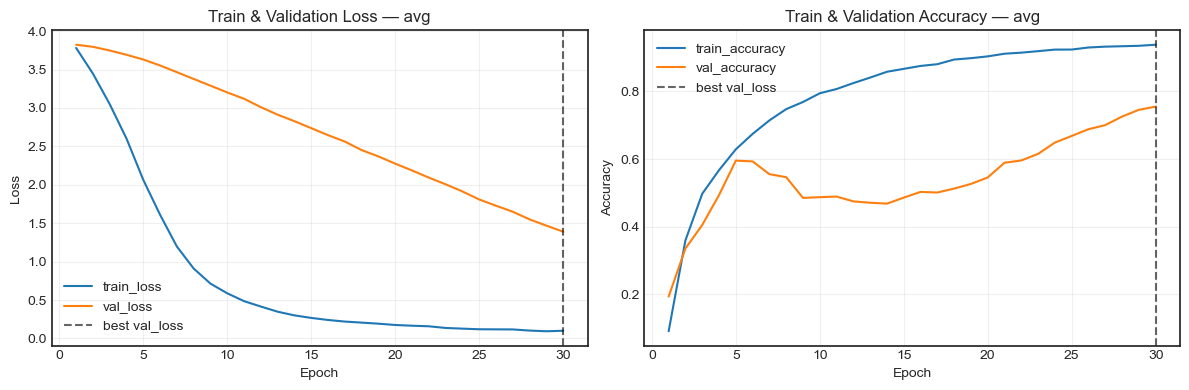

[TEST:avg] loss=1.4163  acc=0.7431
              precision    recall  f1-score   support

           0     0.8889    0.6667    0.7619        12
           1     0.7889    0.6762    0.7282       105
           2     0.8333    0.7500    0.7895        20
           3     0.6963    0.9729    0.8117       813
           4     0.8938    0.7637    0.8237       474
           5     0.0000    0.0000    0.0000         5
           6     1.0000    0.5000    0.6667        14
           7     1.0000    0.6667    0.8000         3
           8     0.7097    0.5789    0.6377        38
           9     0.8421    0.6400    0.7273        25
          10     0.9167    0.7333    0.8148        30
          11     0.7013    0.6506    0.6750        83
          12     0.7143    0.3846    0.5000        13
          13     0.5789    0.2973    0.3929        37
          14     0.2500    0.5000    0.3333         2
          15     0.5000    0.1111    0.1818         9
          16     0.6635    0.6970    0.6798   

c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [13]:
def build_avg(max_words, maxlen, num_classes, emb_dim=128):
    m = models.Sequential([layers.Input((maxlen,)), 
                           layers.Embedding(max_words, emb_dim, mask_zero=True),
                           layers.GlobalAveragePooling1D(),
                           layers.BatchNormalization(),
                           layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
                           layers.Dropout(0.5),
                           layers.Dense(num_classes, activation='softmax')])
    m.compile(optimizer=optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return m

model_avg, hist_avg = train_and_eval(build_avg, "avg", use_class_weight=True, epochs=30, batch_size=512)

- (수정) epoch/batch_size 증가 + EarlyStopping, embedding 차원 증가 


==== Train avg_tuned ====
Epoch 1/80
27/27 [==============================] - ETA: 0s - loss: 3.7907 - accuracy: 0.0763
Epoch 1: val_loss improved from inf to 3.81189, saving model to reuters_avg_tuned_best.h5
27/27 [==============================] - 4s 107ms/step - loss: 3.7907 - accuracy: 0.0763 - val_loss: 3.8119 - val_accuracy: 0.2760 - lr: 0.0010
Epoch 2/80
 1/27 [>.............................] - ETA: 2s - loss: 3.6179 - accuracy: 0.2070

c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - ETA: 0s - loss: 3.4809 - accuracy: 0.2684
Epoch 2: val_loss improved from 3.81189 to 3.77180, saving model to reuters_avg_tuned_best.h5
27/27 [==============================] - 3s 105ms/step - loss: 3.4809 - accuracy: 0.2684 - val_loss: 3.7718 - val_accuracy: 0.4279 - lr: 0.0010
Epoch 3/80
27/27 [==============================] - ETA: 0s - loss: 2.9983 - accuracy: 0.3725
Epoch 3: val_loss improved from 3.77180 to 3.68653, saving model to reuters_avg_tuned_best.h5
27/27 [==============================] - 3s 100ms/step - loss: 2.9983 - accuracy: 0.3725 - val_loss: 3.6865 - val_accuracy: 0.5156 - lr: 0.0010
Epoch 4/80
26/27 [===========================>..] - ETA: 0s - loss: 2.3866 - accuracy: 0.4600
Epoch 4: val_loss improved from 3.68653 to 3.55890, saving model to reuters_avg_tuned_best.h5
27/27 [==============================] - 3s 101ms/step - loss: 2.3883 - accuracy: 0.4595 - val_loss: 3.5589 - val_accuracy: 0.5427 - lr: 0.0010
Epoch 5/80
27/2

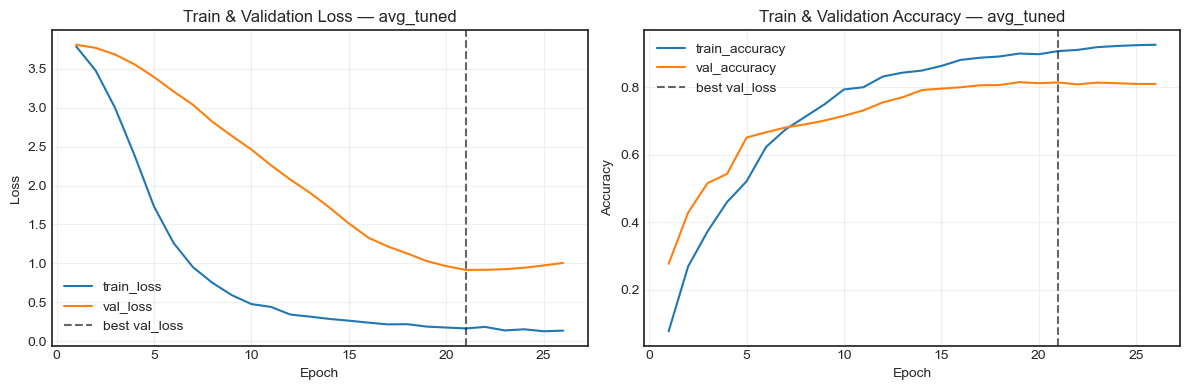

[TEST:avg_tuned] loss=0.9173  acc=0.8028
              precision    recall  f1-score   support

           0     0.8889    0.6667    0.7619        12
           1     0.7297    0.7714    0.7500       105
           2     0.6957    0.8000    0.7442        20
           3     0.9201    0.9348    0.9274       813
           4     0.8394    0.8713    0.8551       474
           5     0.0000    0.0000    0.0000         5
           6     0.8000    0.8571    0.8276        14
           7     1.0000    1.0000    1.0000         3
           8     0.6190    0.6842    0.6500        38
           9     0.8000    0.9600    0.8727        25
          10     0.8710    0.9000    0.8852        30
          11     0.6620    0.5663    0.6104        83
          12     0.4667    0.5385    0.5000        13
          13     0.6562    0.5676    0.6087        37
          14     0.2500    0.5000    0.3333         2
          15     0.5000    0.2222    0.3077         9
          16     0.6636    0.7172    0.6

c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [17]:
def build_avg(max_words, maxlen, num_classes, emb_dim=200, hidden1=256, hidden2=128, dp=0.5):
    m = models.Sequential([layers.Input((maxlen,)),
                           layers.Embedding(max_words, emb_dim, mask_zero=True),
                           layers.GlobalAveragePooling1D(),
                           layers.BatchNormalization(),
                           layers.Dense(hidden1, activation='relu', kernel_initializer='he_normal'),
                           layers.Dropout(dp),
                           layers.Dense(hidden2, activation='relu', kernel_initializer='he_normal'),
                           layers.Dropout(dp),
                           layers.Dense(num_classes, activation='softmax')])
    m.compile(optimizer=optimizers.Adam(1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return m

model_avg, hist_avg = train_and_eval(builder=lambda *args, **kw: build_avg(max_words, maxlen, num_classes, emb_dim=200),
                                     name="avg_tuned", use_class_weight=True, epochs=80, batch_size=256)

### 텍스트 CNN


==== Train cnn ====
Epoch 1/30
27/27 [==============================] - ETA: 0s - loss: 6.3004 - accuracy: 0.0297
Epoch 1: val_loss improved from inf to 3.76860, saving model to reuters_cnn_best.h5
27/27 [==============================] - 17s 601ms/step - loss: 6.3004 - accuracy: 0.0297 - val_loss: 3.7686 - val_accuracy: 0.0178 - lr: 0.0010
Epoch 2/30


c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - ETA: 0s - loss: 4.6500 - accuracy: 0.0344
Epoch 2: val_loss did not improve from 3.76860
27/27 [==============================] - 16s 605ms/step - loss: 4.6500 - accuracy: 0.0344 - val_loss: 3.7800 - val_accuracy: 0.0298 - lr: 0.0010
Epoch 3/30
27/27 [==============================] - ETA: 0s - loss: 4.3845 - accuracy: 0.0279
Epoch 3: val_loss did not improve from 3.76860

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
27/27 [==============================] - 16s 602ms/step - loss: 4.3845 - accuracy: 0.0279 - val_loss: 3.7855 - val_accuracy: 0.0013 - lr: 0.0010
Epoch 4/30
27/27 [==============================] - ETA: 0s - loss: 4.2131 - accuracy: 0.0291
Epoch 4: val_loss did not improve from 3.76860
27/27 [==============================] - 16s 609ms/step - loss: 4.2131 - accuracy: 0.0291 - val_loss: 3.7694 - val_accuracy: 0.0013 - lr: 5.0000e-04
Epoch 5/30
27/27 [==============================] - ETA: 0s - loss: 4.14

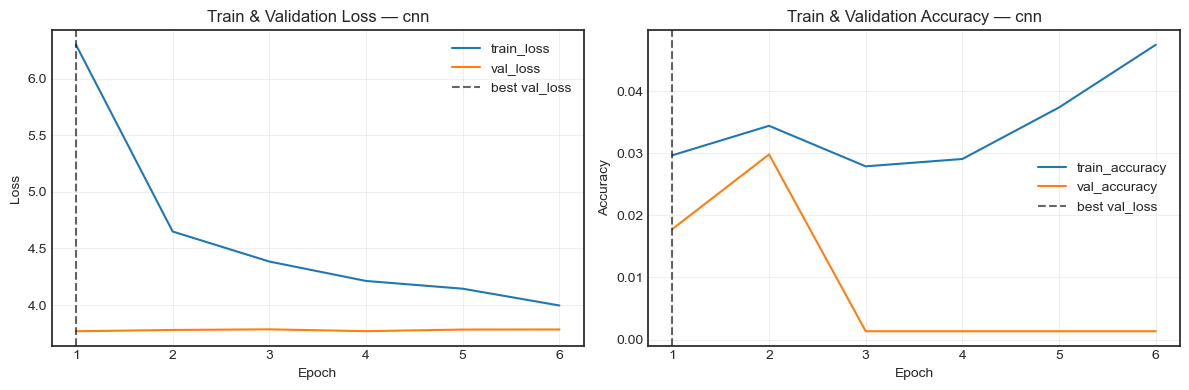

[TEST:cnn] loss=3.7682  acc=0.0174
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        12
           1     0.0175    0.0095    0.0123       105
           2     0.0000    0.0000    0.0000        20
           3     0.0000    0.0000    0.0000       813
           4     0.0000    0.0000    0.0000       474
           5     0.0000    0.0000    0.0000         5
           6     0.0000    0.0000    0.0000        14
           7     0.0000    0.0000    0.0000         3
           8     0.0162    0.8421    0.0317        38
           9     0.0000    0.0000    0.0000        25
          10     0.0000    0.0000    0.0000        30
          11     0.0930    0.0482    0.0635        83
          12     0.0000    0.0000    0.0000        13
          13     0.0000    0.0000    0.0000        37
          14     0.0000    0.0000    0.0000         2
          15     0.0000    0.0000    0.0000         9
          16     0.0000    0.0000    0.0000   

c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [14]:
def build_cnn(max_words, maxlen, num_classes, emb_dim=128):
    m = models.Sequential([layers.Input((maxlen,)),
                           layers.Embedding(max_words, emb_dim),
                           layers.Conv1D(128, 5, padding='same', use_bias=False), 
                           layers.BatchNormalization(), layers.ReLU(),
                           layers.MaxPooling1D(2),
                           layers.Conv1D(128, 3, padding='same', use_bias=False), 
                           layers.BatchNormalization(), 
                           layers.ReLU(),
                           layers.GlobalMaxPooling1D(),
                           layers.Dropout(0.5),
                           layers.Dense(num_classes, activation='softmax')])
    m.compile(optimizer=optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return m

model_cnn, hist_cnn = train_and_eval(build_cnn, "cnn", use_class_weight=True, epochs=30, batch_size=256)

- (수정) Embedding -> SpatialDropout1D -> [Conv1D(k) + GlobalMaxPool]×N -> concat -> Dropout -> Dense

In [18]:
def build_textcnn_seq(max_words, maxlen, num_classes, emb_dim=128, filters=128, 
                      kernel_sizes=(3,4,5), dropout=0.5, lr=1e-3):
    
    class TextCNNMultiKernel(layers.Layer):
        def __init__(self, filters, kernel_sizes, **kwargs):
            super().__init__(**kwargs)
            self.convs = [layers.Conv1D(filters, k, padding='valid', activation='relu', kernel_initializer='he_normal', 
                                        use_bias=True)for k in kernel_sizes]
            self.gmp = layers.GlobalMaxPooling1D()

        def call(self, x):                 
            branches = [self.gmp(conv(x)) for conv in self.convs]
            return tf.concat(branches, axis=-1)

    model = models.Sequential([layers.Input(shape=(maxlen,)),
                               layers.Embedding(max_words, emb_dim, mask_zero=False),
                               layers.SpatialDropout1D(0.2),
                               TextCNNMultiKernel(filters=filters, kernel_sizes=kernel_sizes, name="textcnn_block"),
                               layers.Dropout(dropout),
                               layers.Dense(num_classes, activation='softmax')])

    model.compile(optimizer=optimizers.Adam(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


==== Train textcnn_seq ====
Epoch 1/30
53/53 [==============================] - ETA: 0s - loss: 3.8543 - accuracy: 0.0181
Epoch 1: val_loss improved from inf to 3.72890, saving model to reuters_textcnn_seq_best.h5
53/53 [==============================] - 21s 383ms/step - loss: 3.8543 - accuracy: 0.0181 - val_loss: 3.7289 - val_accuracy: 0.2836 - lr: 0.0010
Epoch 2/30


c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - ETA: 0s - loss: 3.7223 - accuracy: 0.1657
Epoch 2: val_loss improved from 3.72890 to 3.60089, saving model to reuters_textcnn_seq_best.h5
53/53 [==============================] - 20s 383ms/step - loss: 3.7223 - accuracy: 0.1657 - val_loss: 3.6009 - val_accuracy: 0.3856 - lr: 0.0010
Epoch 3/30
53/53 [==============================] - ETA: 0s - loss: 3.5477 - accuracy: 0.3229
Epoch 3: val_loss improved from 3.60089 to 3.21851, saving model to reuters_textcnn_seq_best.h5
53/53 [==============================] - 20s 370ms/step - loss: 3.5477 - accuracy: 0.3229 - val_loss: 3.2185 - val_accuracy: 0.4288 - lr: 0.0010
Epoch 4/30
53/53 [==============================] - ETA: 0s - loss: 3.2152 - accuracy: 0.3858
Epoch 4: val_loss improved from 3.21851 to 2.79178, saving model to reuters_textcnn_seq_best.h5
53/53 [==============================] - 22s 411ms/step - loss: 3.2152 - accuracy: 0.3858 - val_loss: 2.7918 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 

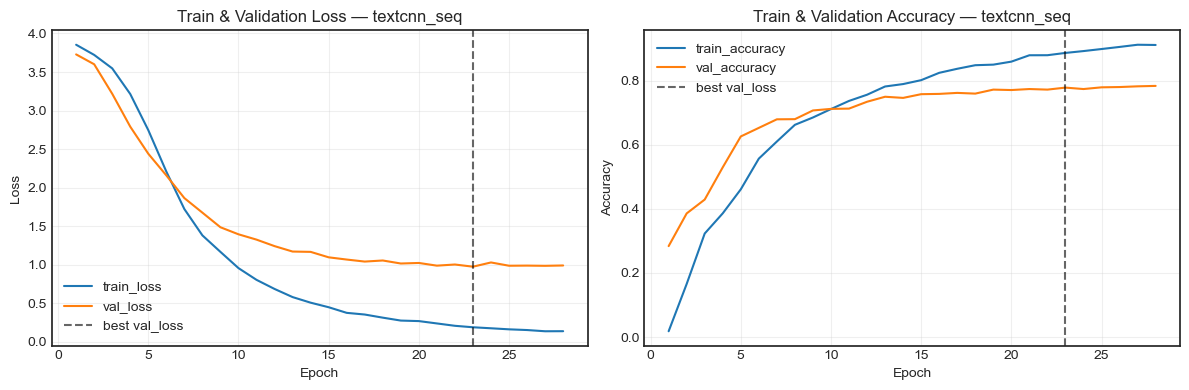

[TEST:textcnn_seq] loss=0.9876  acc=0.7747
              precision    recall  f1-score   support

           0     0.9000    0.7500    0.8182        12
           1     0.7353    0.7143    0.7246       105
           2     0.6957    0.8000    0.7442        20
           3     0.9466    0.8512    0.8964       813
           4     0.7829    0.8291    0.8053       474
           5     0.0000    0.0000    0.0000         5
           6     0.9286    0.9286    0.9286        14
           7     0.7500    1.0000    0.8571         3
           8     0.6500    0.6842    0.6667        38
           9     0.8333    1.0000    0.9091        25
          10     0.9062    0.9667    0.9355        30
          11     0.6812    0.5663    0.6184        83
          12     0.5000    0.6154    0.5517        13
          13     0.5476    0.6216    0.5823        37
          14     0.2857    1.0000    0.4444         2
          15     0.5000    0.1111    0.1818         9
          16     0.6341    0.7879    0

c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [19]:
model_tcnn, hist_tcnn = train_and_eval(builder=lambda *args, 
                                       **kw: build_textcnn_seq(max_words,maxlen,num_classes,emb_dim=128,filters=128,
                                                               kernel_sizes=(3,4,5),dropout=0.5,lr=1e-3),
                                       name="textcnn_seq", use_class_weight=True, epochs=30, batch_size=128)

### BiLSTM


==== Train bilstm ====
Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 3.7511 - accuracy: 0.1453
Epoch 1: val_loss improved from inf to 3.78526, saving model to reuters_bilstm_best.h5
27/27 [==============================] - 86s 3s/step - loss: 3.7511 - accuracy: 0.1453 - val_loss: 3.7853 - val_accuracy: 0.3691 - lr: 0.0010
Epoch 2/20


c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - ETA: 0s - loss: 2.8883 - accuracy: 0.3965
Epoch 2: val_loss improved from 3.78526 to 3.70006, saving model to reuters_bilstm_best.h5
27/27 [==============================] - 94s 3s/step - loss: 2.8883 - accuracy: 0.3965 - val_loss: 3.7001 - val_accuracy: 0.3330 - lr: 0.0010
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 1.6856 - accuracy: 0.5129
Epoch 3: val_loss improved from 3.70006 to 3.63271, saving model to reuters_bilstm_best.h5
27/27 [==============================] - 98s 4s/step - loss: 1.6856 - accuracy: 0.5129 - val_loss: 3.6327 - val_accuracy: 0.2302 - lr: 0.0010
Epoch 4/20
27/27 [==============================] - ETA: 0s - loss: 0.8990 - accuracy: 0.6102
Epoch 4: val_loss improved from 3.63271 to 3.44844, saving model to reuters_bilstm_best.h5
27/27 [==============================] - 99s 4s/step - loss: 0.8990 - accuracy: 0.6102 - val_loss: 3.4484 - val_accuracy: 0.4297 - lr: 0.0010
Epoch 5/20
27/27 [============

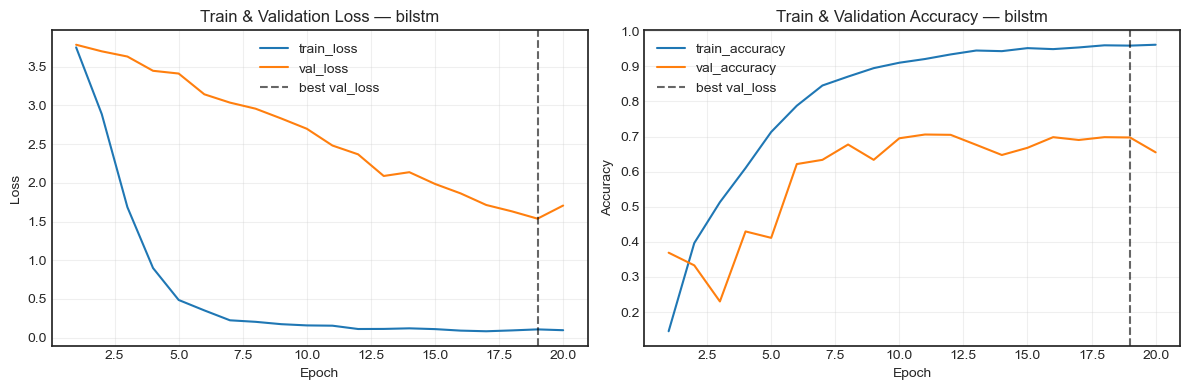

[TEST:bilstm] loss=1.6478  acc=0.6674
              precision    recall  f1-score   support

           0     0.5455    0.5000    0.5217        12
           1     0.4907    0.7524    0.5940       105
           2     0.6250    0.5000    0.5556        20
           3     0.9460    0.8401    0.8899       813
           4     0.8486    0.7215    0.7799       474
           5     0.0000    0.0000    0.0000         5
           6     1.0000    0.5714    0.7273        14
           7     1.0000    0.3333    0.5000         3
           8     0.6341    0.6842    0.6582        38
           9     0.9375    0.6000    0.7317        25
          10     0.7812    0.8333    0.8065        30
          11     0.6667    0.2169    0.3273        83
          12     0.4286    0.4615    0.4444        13
          13     0.2111    0.5135    0.2992        37
          14     0.1000    0.5000    0.1667         2
          15     0.0000    0.0000    0.0000         9
          16     0.6571    0.4646    0.5444

c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [15]:
def build_bilstm(max_words, maxlen, num_classes, emb_dim=128):
    m = models.Sequential([layers.Input((maxlen,)),
                           layers.Embedding(max_words, emb_dim, mask_zero=True),
                           layers.Bidirectional(layers.LSTM(64)),
                           layers.BatchNormalization(),
                           layers.Dropout(0.5),
                           layers.Dense(num_classes, activation='softmax')])
    m.compile(optimizer=optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return m

model_lstm, hist_lstm = train_and_eval(build_bilstm, "bilstm", use_class_weight=True, epochs=20, batch_size=256)